In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [85]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [86]:
os.chdir('/home/MA')

For Switzerland, a weather station near Zurich airport was chosen (LSZH)

In [87]:
HDD_CH = pd.read_csv('Data/LSZH_HDD_12C.csv')

For Norway, ENTO station south of Oslo was chosen

In [88]:
HDD_Norway = pd.read_csv('Data/ENTO_HDD_12C.csv')

In [89]:
load_CH = pd.read_pickle('Calculations/CH/load_CH_separated.pkl')

Goal: to recreate a heating demand profile for Norway based on the one provided for Switzerland.
Approach: Divide all heating energy by total of heating degree days for Switzerland, then multiply Norway's heating degree days

Calculations were carried out with base temperature of 12° Celsius which is a valid assumption based on https://www.sciencedirect.com/science/article/pii/S2352710218301086#:~:text=The%20air%20temperature%20is%20defined,the%20basis%20for%20climate%20classification.
Source for heating days : https://www.degreedays.net/#

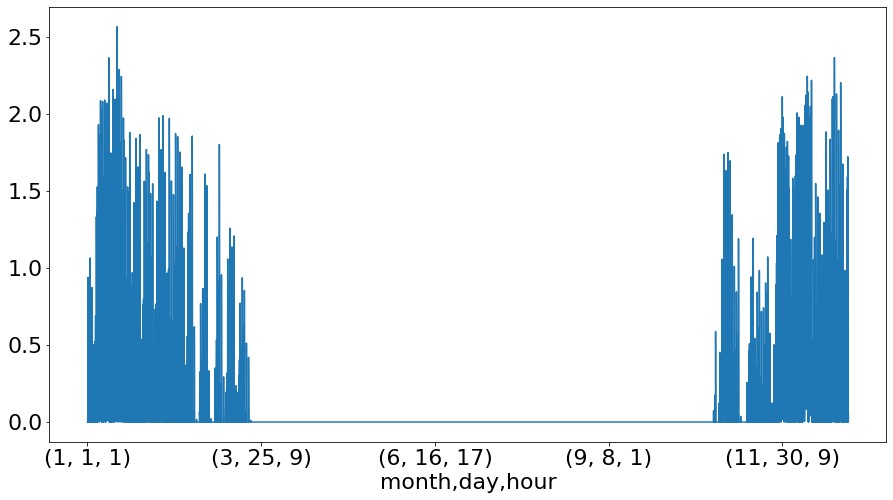

In [109]:
load_CH['Electricity for Space Heating [kWh]'].plot();

In [164]:
Total_elec_heating_CH = sum(load_CH['Electricity for Space Heating [kWh]'])

In [165]:
Total_elec_heating_CH

1034.6743396814395

In [93]:
HDD_Norway['Date'] = pd.to_datetime(HDD_Norway['Date'], format='%d-%m-%y')

In [94]:
HDD_Norway = HDD_Norway[~((HDD_Norway.Date.dt.month == 2) & (HDD_Norway.Date.dt.day == 29))]

In [95]:
HDD_Norway_averaged = HDD_Norway.groupby([HDD_Norway["Date"].dt.month, HDD_Norway["Date"].dt.day, HDD_Norway["Date"].dt.hour]).mean()

In [96]:
HDD_Norway_averaged.index.names = ["month", "day", "hour"]

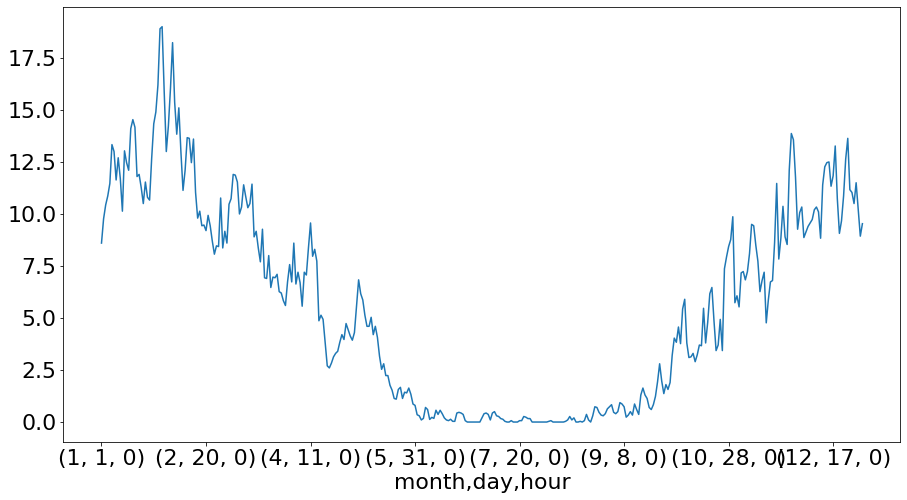

In [97]:
HDD_Norway_averaged['HDD 12'].plot();

In [98]:
HDD_CH['Date'] = pd.to_datetime(HDD_CH['Date'], format='%d-%m-%y')

In [99]:
HDD_CH = HDD_CH[~((HDD_CH.Date.dt.month == 2) & (HDD_CH.Date.dt.day == 29))]

In [100]:
HDD_CH_averaged = HDD_CH.groupby([HDD_CH["Date"].dt.month, HDD_CH["Date"].dt.day, HDD_CH["Date"].dt.hour]).mean()

In [101]:
HDD_CH_averaged.index.names = ["month", "day", "hour"]

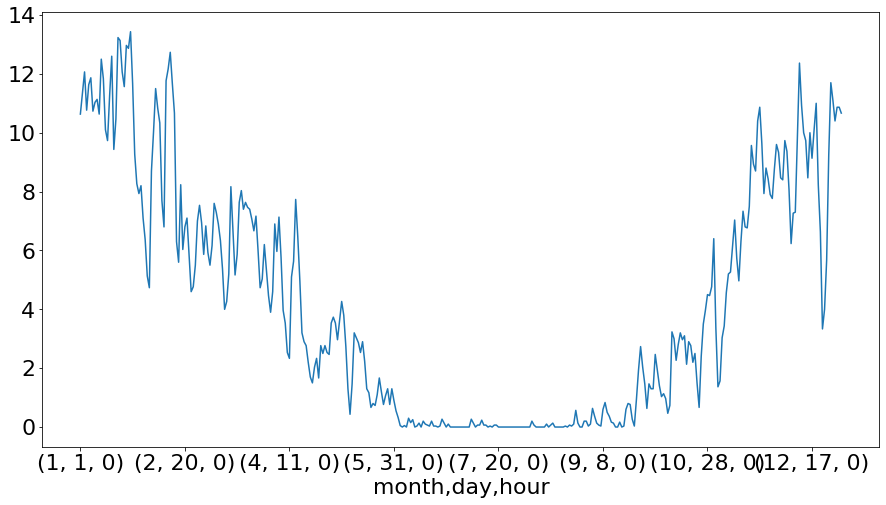

In [102]:
HDD_CH_averaged['HDD 12'].plot();

In [103]:
Total_HDD_CH = sum(HDD_CH_averaged['HDD 12'])
Total_HDD_CH

1523.0083333333332

In [104]:
Total_HDD_Norway = sum(HDD_Norway_averaged['HDD 12'])
Total_HDD_Norway

2039.9166666666645

In [105]:
ratio = Total_HDD_Norway/Total_HDD_CH

In [106]:
load_Norway = load_CH.copy()

In [107]:
load_Norway['Electricity for Space Heating [kWh]'] = ratio * load_Norway['Electricity for Space Heating [kWh]']

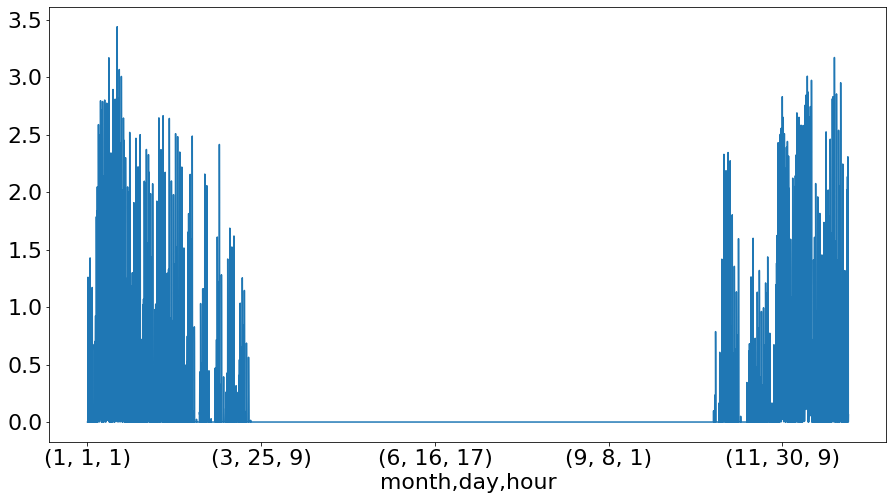

In [108]:
load_Norway['Electricity for Space Heating [kWh]'].plot();

Alternative method: Reproduce a hourly profile for new locations based on climate pattern averaging Switzerland's daily profile

In [120]:
load_CH.index.get_level_values('hour')

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='hour', length=8760)

In [121]:
heating_hourly_averaged_CH = load_CH['Electricity for Space Heating [kWh]'].groupby(load_CH.index.get_level_values('hour')).mean()

In [127]:
heating_hourly_normalized_CH = heating_hourly_averaged_CH/sum(heating_hourly_averaged_CH)

In [147]:
heating_hourly_normalized_CH

hour
0     0.002656
1     0.004483
2     0.006563
3     0.009003
4     0.011640
5     0.014603
6     0.016805
7     0.179140
8     0.148822
9     0.003278
10    0.005647
11    0.004871
12    0.004658
13    0.096371
14    0.063305
15    0.000150
16    0.001014
17    0.001871
18    0.092708
19    0.075385
20    0.069986
21    0.088585
22    0.097997
23    0.000458
Name: Electricity for Space Heating [kWh], dtype: float64

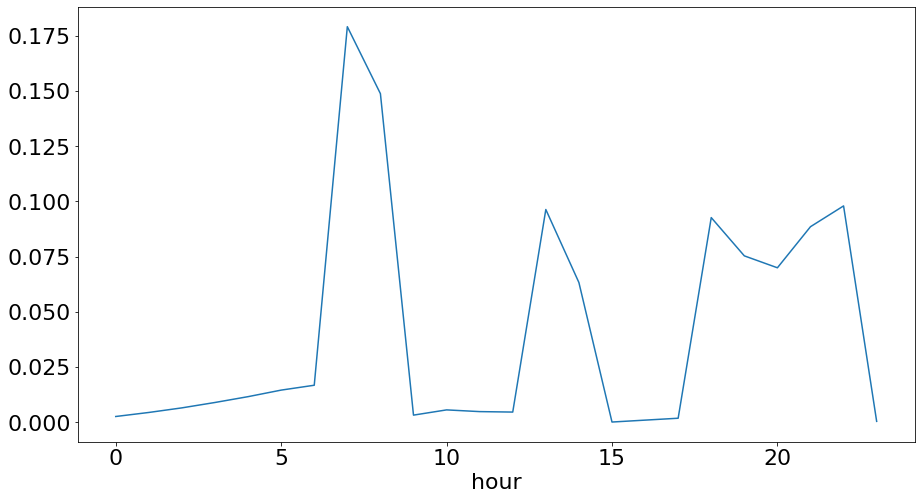

In [128]:
heating_hourly_normalized_CH.plot();

In [ ]:
load_Norway = load_CH.copy()

In [130]:
ratio_CH = Total_elec_heating_CH/Total_HDD_CH
ratio_CH # kWh/HDD

0.679362231339141

In [138]:
HDD_Norway_averaged['HDD 12'].repeat(24)

month  day  hour
1      1    0       8.600000
            0       8.600000
            0       8.600000
            0       8.600000
            0       8.600000
                      ...   
12     31   0       9.533333
            0       9.533333
            0       9.533333
            0       9.533333
            0       9.533333
Name: HDD 12, Length: 8760, dtype: float64

In [155]:
heating_hourly_normalized_CH_df = np.tile(heating_hourly_normalized_CH, 365)
len(heating_hourly_normalized_CH_df)

8760

In [158]:
load_Norway['Electricity for Space Heating [kWh]'] = HDD_Norway_averaged['HDD 12'].repeat(24).values * heating_hourly_normalized_CH_df * ratio_CH

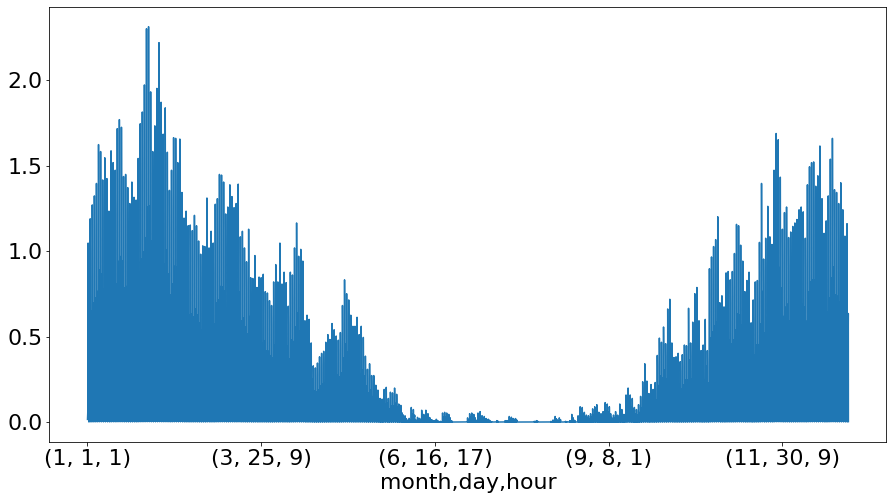

In [176]:
load_Norway['Electricity for Space Heating [kWh]'].plot();

In [162]:
sum(load_Norway['Electricity for Space Heating [kWh]'])

1385.8423384125717

In [167]:
crosscheck = Total_elec_heating_CH*Total_HDD_Norway/Total_HDD_CH
crosscheck

1385.8423384125679

In [183]:
load_Norway['Total Electricity'] = load_Norway['Electricity demand [kWh](Hourly) '] + load_Norway['Electricity for Space Heating [kWh]'] + load_Norway['Electricity for Hot Water [kWh]'] + load_Norway['Electricity for Space Cooling [kWh]']

In [168]:
load_Norway['Total Electricity without AC'] = load_Norway['Electricity demand [kWh](Hourly) '] + load_Norway['Electricity for Space Heating [kWh]'] + load_Norway['Electricity for Hot Water [kWh]']

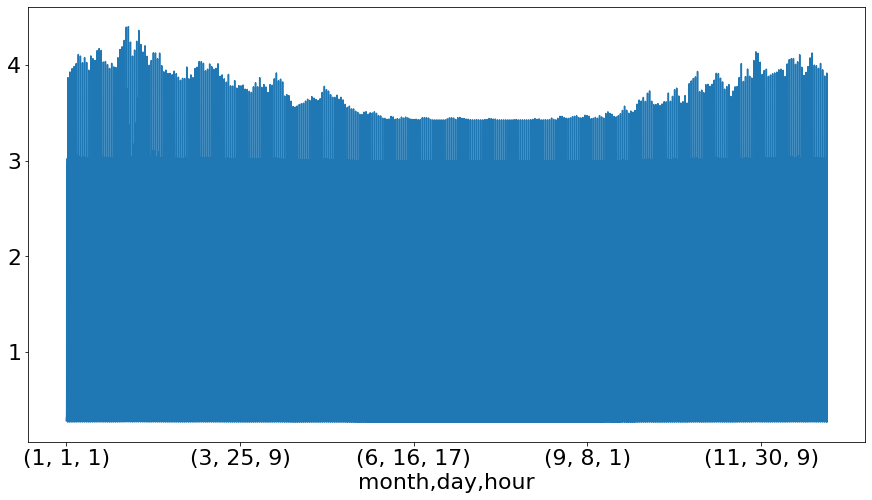

In [179]:
load_Norway['Total Electricity without AC'].plot()

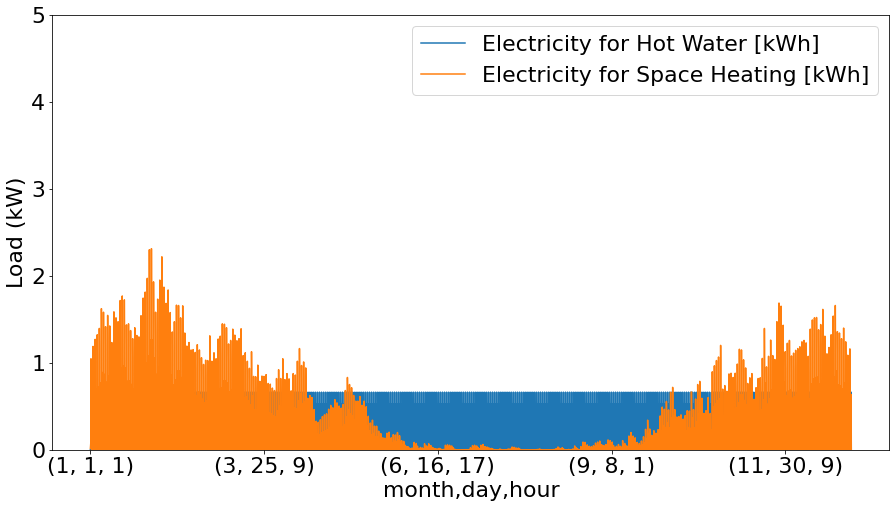

In [182]:
load_Norway[['Electricity for Hot Water [kWh]', 'Electricity for Space Heating [kWh]']].plot(ylabel = 'Load (kW)', ylim = ([0, 5]));

In [180]:
load_Norway['Total Electricity without AC'].to_pickle('Calculations/Norway/load_Norway_modern_full_retrofit_no_AC.pkl')

In [184]:
load_Norway['Total Electricity'].to_pickle('Calculations/Norway/load_Norway_modern_full_retrofit.pkl')